In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
#dimension of one input image to the discriminator
input_dim = 784

#dimension of noise vector to the generator
noise_dim = 50

#number of neurons in the hidden layer of the discriminator
neuron_dim = 128

#number of classes of digits in mnist
y_dim = 10
mnist = input_data.read_data_sets('MNIST_data/',one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
def weight_initialize(size):
    dim = size[0]
    stdev = 1. / tf.sqrt(dim / 2.)
    return tf.random_normal(shape=size, stddev=stdev)

# y vector on which the network is conditioned on
y = tf.placeholder(tf.float32, shape=[None, y_dim])

# input to the discriminator
# None is used to automatically adjust according to bumber of input images in a batch
X = tf.placeholder(tf.float32, shape=[None, input_dim])

# Weights are intitialized between the first hidden layer and the input layer
# Shape --> input_dim x neuron_dim
Disc_W1 = tf.Variable(weight_initialize([input_dim + y_dim, neuron_dim]))
# Biases are intialized to zeros
Disc_b1 = tf.Variable(tf.zeros(shape=[neuron_dim]))

# Weights are intialized between hidden layer and output node
# Shape --> neuron_dim x 1
Disc_W2 = tf.Variable(weight_initialize([neuron_dim, 1]))
# Biases are intialized to zeros
Disc_b2 = tf.Variable(tf.zeros(shape=[1]))

# Discriminator variable
var_D = [Disc_W1, Disc_W2, Disc_b1, Disc_b2]

# input noise to the generator
z = tf.placeholder(tf.float32, shape=[None, noise_dim])

# Weights are intialized between noise layer and first hidden layer
# Shape --> noise_dim x neuron_dim
Genr_W1 = tf.Variable(weight_initialize([noise_dim + y_dim, neuron_dim]))
# Biases are intialized to zeros
Genr_b1 = tf.Variable(tf.zeros(shape=[neuron_dim]))

# Weights are intialized between hidden layer and output layer (generated image)
# Shape --> neuron_dim x input_dim
Genr_W2 = tf.Variable(weight_initialize([neuron_dim, input_dim]))
# Biases are intialized to zeros
Genr_b2 = tf.Variable(tf.zeros(shape=[input_dim]))

# Generator variable
var_G = [Genr_W1, Genr_W2, Genr_b1, Genr_b2]

def generator(z, y):
    inputs = tf.concat(axis=1, values=[z,y])
    # [None, noise_dim] x [noise_dim, neuron_dim] = None, neuron_dim
    Genr_h = tf.nn.relu(tf.matmul(inputs, Genr_W1) + Genr_b1)
    # [None, neuron_dim] x [neuron_dim, input_dim] = None, input_dim
    Genr_log_prob = tf.matmul(Genr_h, Genr_W2) + Genr_b2
    Genr_prob = tf.nn.sigmoid(Genr_log_prob)
    return Genr_prob

def discriminator(x, y):
    inputs = tf.concat(axis=1, values=[x,y])
    # [None, input_dim] x [input_dim, neuron_dim] = None, neuron_dim
    Disc_h = tf.nn.relu(tf.matmul(inputs, Disc_W1) + Disc_b1)
    # [None, neuron_dim] x [neuron_dim, 1] = None, 1
    Disc_log_prob = tf.matmul(Disc_h, Disc_W2) + Disc_b2
    return Disc_log_prob

In [4]:
G_sample = generator(z, y)
D_real = discriminator(X, y)
D_fake = discriminator(G_sample, y)

D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake) # Maximize this
G_loss = -tf.reduce_mean(D_fake) # Minimize this

D_solver = (tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(-D_loss, var_list=var_D))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(G_loss, var_list=var_G))

clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in var_D]

batch_size = 50

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Loop: 0, Generator_loss: 0.018894, Discriminator_loss: 0.012987


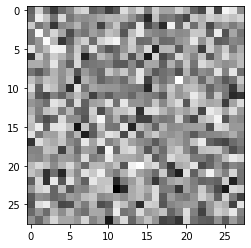

Loop: 100, Generator_loss: 1.8432, Discriminator_loss: 2.1226
Loop: 200, Generator_loss: 1.6389, Discriminator_loss: 1.9676
Loop: 300, Generator_loss: 1.2923, Discriminator_loss: 1.6613
Loop: 400, Generator_loss: 0.99922, Discriminator_loss: 1.3749
Loop: 500, Generator_loss: 0.89906, Discriminator_loss: 1.0589
Loop: 600, Generator_loss: 0.80923, Discriminator_loss: 0.68973
Loop: 700, Generator_loss: 0.55546, Discriminator_loss: 0.44057
Loop: 800, Generator_loss: 0.23311, Discriminator_loss: 0.25526
Loop: 900, Generator_loss: 0.091487, Discriminator_loss: 0.12092


In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

disc_loss = []
genr_loss = []

disc_loss_exp = []
genr_loss_exp = []

saver = tf.train.Saver()
#1000000
for it in range(1000):
    for _ in range(5):
        X_mb, y_mb = mnist.train.next_batch(batch_size)

        _, D_loss_curr, _ = sess.run(
            [D_solver, D_loss, clip_D],
            feed_dict={X: X_mb, y: y_mb, z: np.random.uniform(-1., 1., size=[batch_size, noise_dim])}
        )

    _, G_loss_curr = sess.run(
        [G_solver, G_loss],
        feed_dict={y:y_mb, z: np.random.uniform(-1., 1., size=[batch_size, noise_dim])}
    )
    
    disc_loss.append(D_loss_curr)
    genr_loss.append(G_loss_curr)
    
    if it % 100 == 0:
        print('Loop: {}, Generator_loss: {:.5}, Discriminator_loss: {:.5}'.format(it,G_loss_curr,D_loss_curr))
        disc_loss_exp.append(D_loss_curr)
        genr_loss_exp.append(G_loss_curr)
        
        if it % 1000 == 0:
            y_req = np.zeros([1,10])
            y_req[:, 2] = 1 # we are generating 2
            samples = sess.run(G_sample, feed_dict={y:y_req, z: np.random.uniform(-1., 1., size=[1, noise_dim])})
            for img in samples:
                plt.imshow(img.reshape([28, 28]), cmap='Greys_r')
                plt.show()

    if it%100000 == 0:
        save_path = saver.save(sess, 'my_cgan_model/final.ckpt')

INFO:tensorflow:Restoring parameters from my_cgan_model/final.ckpt


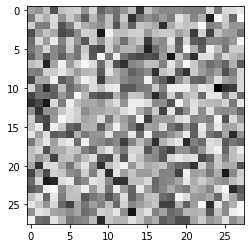

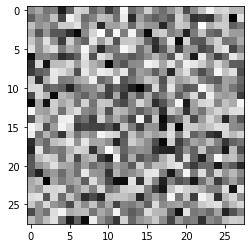

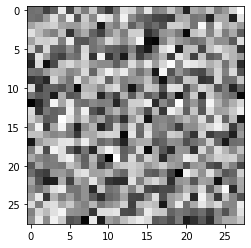

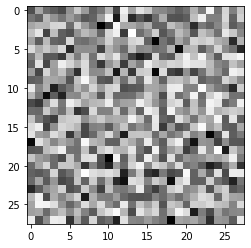

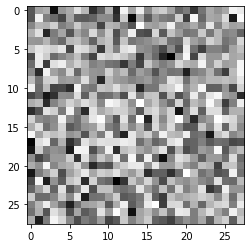

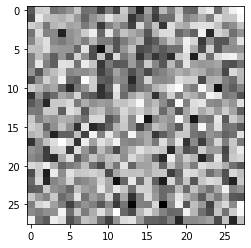

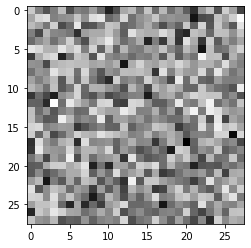

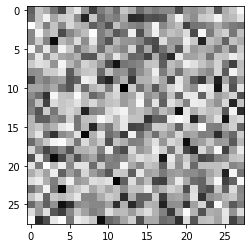

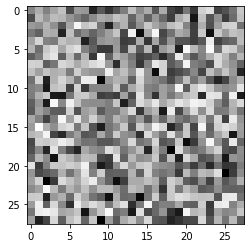

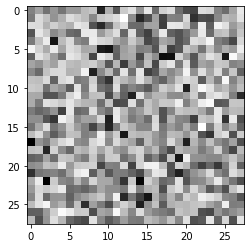

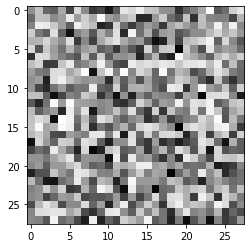

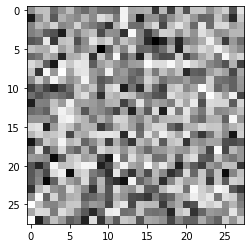

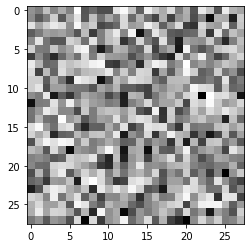

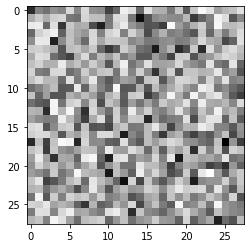

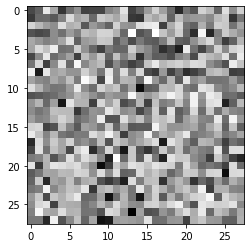

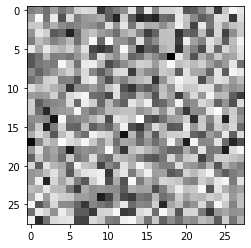

In [7]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'my_cgan_model/final.ckpt')
    y_req = np.zeros([16, 10])
    y_req[:,3] = 1
    samples = sess.run(G_sample, feed_dict={y:y_req, z: np.random.uniform(-1., 1., size=[16, noise_dim])})
    
    for img in samples:
        plt.imshow(img.reshape([28, 28]), cmap='Greys_r')
        plt.show()
